In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

C:\Users\vas\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [32]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [3]:
data.test.labels[0:5, :]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [4]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])
data.test.cls[0:5]

array([7, 2, 1, 0, 4], dtype=int64)

In [5]:
from argparse import Namespace
args = Namespace(img_size = 28,
    img_size_flat = 28 * 28,
    img_shape = (28, 28),
    num_classes = 10)

In [6]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(args.img_shape), cmap=plt.cm.plasma)
        
        if cls_pred is None:
            xlabel = 'True: {0}'.format(cls_true[i])
        else:
            xlabel = 'True: {0}, Pred: {1}'.format(cls_true[i], cls_pred[i])
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

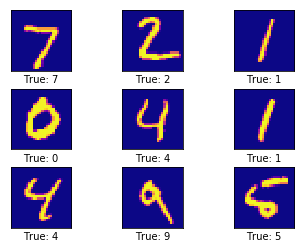

In [7]:
images = data.test.images [0 : 9]
cls_true = data.test.cls [0 : 9]
plot_images(images=images, cls_true=cls_true)

In [8]:
x = tf.placeholder(tf.float32, [None, args.img_size_flat])
y_true = tf.placeholder(tf.float32, [None, args.num_classes])
y_true_cls = tf.placeholder(tf.int64, [None])

In [9]:
weights = tf.Variable(tf.zeros([args.img_size_flat, args.num_classes]))
biases = tf.Variable(tf.zeros([args.num_classes]))

In [10]:
logit = tf.matmul(x, weights) + biases

In [11]:
y_pred = tf.nn.softmax(logit)

In [12]:
y_pred_cls = tf.argmax(y_pred, axis=1)

In [13]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit, labels=y_true)

In [14]:
cost = tf.reduce_mean(cross_entropy)

In [15]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.3).minimize(cost)

In [16]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [17]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [18]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [19]:
batch_size = 100

In [20]:
def optimize(num_iterations):
    for i in range(num_iterations):
        x_batch, y_true_batch = data.train.next_batch(batch_size=batch_size)
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        session.run(optimizer, feed_dict=feed_dict_train)

In [21]:
feed_dict_test = {x: data.test.images,
                 y_true: data.test.labels,
                 y_true_cls: data.test.cls}

In [22]:
def print_accuracy():
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    print('Accuracy on test=set: {0:.1%}'.format(acc))

In [23]:
print_accuracy()

Accuracy on test=set: 9.8%


In [24]:
%%time
optimize(num_iterations=10)
print_accuracy()

Accuracy on test=set: 78.3%
Wall time: 132 ms


In [25]:
%%time
optimize(num_iterations=990)
print_accuracy()

Accuracy on test=set: 91.9%
Wall time: 583 ms


In [26]:
def print_confusion_matrix():
    
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    
    cm = confusion_matrix(y_pred=cls_pred, y_true=data.test.cls)
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuPu)
    
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(args.num_classes)
    plt.xticks(tick_marks)
    plt.yticks(tick_marks)
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.show()

[[ 961    0    3    3    0    3    7    1    2    0]
 [   0 1107    3    2    0    3    4    1   15    0]
 [   8    4  933   13   12    1   10   12   31    8]
 [   3    0   28  921    0   19    2   10   17   10]
 [   1    2    7    2  916    1    9    2    8   34]
 [  10    3    9   46    9  758   14    7   28    8]
 [  12    3    4    2   11   15  909    1    1    0]
 [   3    9   26    8    9    0    0  939    2   32]
 [   8   10   10   29    9   26   11   13  845   13]
 [  12    7    3   13   36    7    0   20    7  904]]


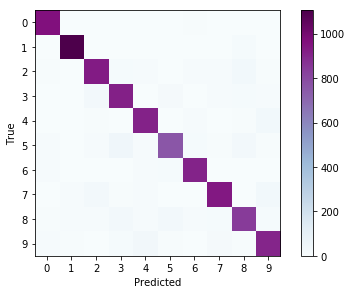

In [27]:
print_confusion_matrix()

In [28]:
def plot_weights():
    w = session.run(weights)
    
    w_min = np.min(w)
    w_max = np.max(w)
    
    fig, axes = plt.subplots(2, 5)
    #fig.subplots_adjust(hspace = 0, wspace = 0.1)
    
    for i, ax in enumerate(axes.flat):
        image = w[:, i].reshape(args.img_shape)

        ax.set_xlabel('Weights: {0}'.format(i))
        ax.imshow(image, vmin = w_min, vmax = w_max, cmap = plt.cm.seismic)
            
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

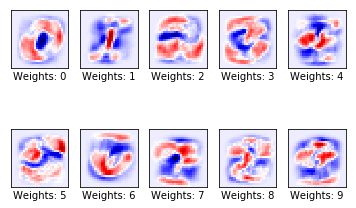

In [29]:
plot_weights()

In [30]:
%%time
optimize(num_iterations=100000)
print_accuracy()

Accuracy on test=set: 92.6%
Wall time: 1min 5s


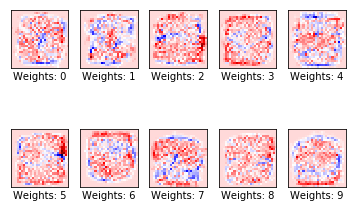

In [31]:
plot_weights()